In [1]:
import os
import pandas as pd
import re
import numpy as np
import glob

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow import keras

from keras.preprocessing.text import Tokenizer

from keras_preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

import json

In [11]:
# This was used to train and read on the the open source sample code

with open('../sample/sample.json', 'r') as f:
  data = json.load(f)

sections = []
importances = []

for file in data:
    # print(file['name'], len(file['sections']))
    for section in file['sections']:
        sections.append(section['raw'])
        if section['importance'] == True:
            importances.append(1)
        else:
            importances.append(0)

print("total: ", len(sections), "importance rate", sum(importances) / len(sections))

total:  687 importance rate 0.12081513828238719


In [14]:
data = pd.DataFrame({"section": sections, "importances": importances}, columns=["section", "importances"])

regex_target = "[^a-zA-z0-9\s\-]" # include -
# regex_target = "[^a-zA-z0-9\s]" # exclude -

data['section'] = data['section'].apply((lambda x: re.sub(regex_target,'',x)))

max_fatures = 2000
tokenizer =  Tokenizer(num_words=max_fatures, split=' ', filters='-!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(data['section'].values)
X = tokenizer.texts_to_sequences(data['section'].values)
X = pad_sequences(X)


# data
for i in range(11):
    word = list(tokenizer.word_index.keys())[i]
    count = tokenizer.word_counts[word]
    print(word, count)




to 1938
move 1595
exit 1361
map 1114
ws 962
send 928
end 872
exec 868
3030 714
perform 708
thru 696


In [15]:
# Y = data['importances'] # for sigmoid
Y = pd.get_dummies(data['importances']).values # for softmax
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 432
Val size: 186
Test size: 69


In [16]:
embed_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(lstm_out, dropout=0.3))
model.add(Dense(2,activation='softmax'))
# model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.Adam(0.0005),metrics = ['accuracy'])
# model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(0.0005),metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 610, 32)           64000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 610, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 72,386
Trainable params: 72,386
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(X_train, Y_train, epochs = 16, batch_size=16, verbose=1, validation_data=(X_train, Y_train))



Epoch 1/16
27/27 [==============================] - 10s 95ms/step - loss: 0.6133 - accuracy: 0.8727 - val_loss: 0.4954 - val_accuracy: 0.8727
Epoch 2/16
27/27 [==============================] - 1s 48ms/step - loss: 0.2992 - accuracy: 0.8727 - val_loss: 0.1920 - val_accuracy: 0.8727
Epoch 3/16
27/27 [==============================] - 1s 43ms/step - loss: 0.1562 - accuracy: 0.8958 - val_loss: 0.1215 - val_accuracy: 0.9398
Epoch 4/16
27/27 [==============================] - 1s 43ms/step - loss: 0.1260 - accuracy: 0.9583 - val_loss: 0.1177 - val_accuracy: 0.9769
Epoch 5/16
27/27 [==============================] - 1s 42ms/step - loss: 0.1058 - accuracy: 0.9653 - val_loss: 0.1015 - val_accuracy: 0.9769
Epoch 6/16
27/27 [==============================] - 1s 47ms/step - loss: 0.0860 - accuracy: 0.9769 - val_loss: 0.0797 - val_accuracy: 0.9745
Epoch 7/16
27/27 [==============================] - 1s 44ms/step - loss: 0.0883 - accuracy: 0.9745 - val_loss: 0.0763 - val_accuracy: 0.9769
Epoch 8/16
2

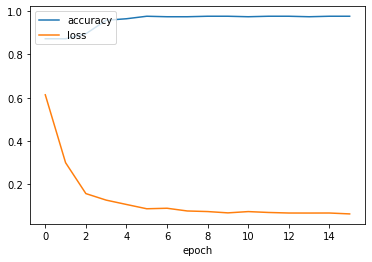

In [18]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['loss'])
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'loss'], loc='upper left')
  plt.show()

plot_history(history)


In [19]:
model.evaluate(X_test, Y_test)

3/3 [==============================] - 1s 55ms/step - loss: 0.0438 - accuracy: 0.9855


[0.04375438764691353, 0.9855072498321533]

In [20]:
predits = model.predict(X_test)

important_predicts = []

for i in range(len(predits)):
    item = predits[i]
    value = item[1]
    if value > 0.5:
        print(i, item)
        important_predicts.append(value)

print(np.mean(important_predicts))



3/3 [==============================] - 1s 57ms/step
7 [0.16513349 0.8348665 ]
17 [0.16630104 0.8336989 ]
18 [0.21844706 0.781553  ]
53 [0.15809341 0.84190655]
56 [0.16791196 0.832088  ]
58 [0.1528613 0.8471387]
60 [0.15643843 0.84356153]
0.83068764


In [21]:
model.save('../model/model_open')


INFO:tensorflow:Assets written to: ../model/model_open\assets


INFO:tensorflow:Assets written to: ../model/model_open\assets
